In [1]:
from scipy.io import loadmat

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

from torch.nn.parameter import Parameter

import numpy as np
import time

import matplotlib.pyplot as plt

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:2


In [2]:
class Sequentialmodel_coPINN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears1 = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears1[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears1[i].bias.data) 
        
        self.beta1 = Parameter(torch.ones((50,len(layers)-2)))
        self.beta1.requiresGrad = True
        
        self.linears2 = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears2[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears2[i].bias.data) 
        
        self.beta2 = Parameter(torch.ones((50,len(layers)-2)))
        self.beta2.requiresGrad = True
    
    'forward pass'
    def forward1(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears1[i](a)
            a = self.activation(z) + self.beta2[:,i]*z*self.activation(z)
            
        a = self.linears1[-1](a) 
         
        return a
    
    def forward2(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears2[i](a)
            a = self.activation(z) + self.beta1[:,i]*z*self.activation(z)
            
        a = self.linears2[-1](a) 
         
        return a
    
    def test(self):
        y_pred = self.forward1(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        # test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        # test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        test_mse = 0
        test_re = 0
        
        return test_mse, test_re
    

class Sequentialmodel_vPINN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((100,len(layers)-2)))
        self.beta.requiresGrad = True
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) #+ self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a

In [3]:
x = np.linspace(0,10,100)
x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    # layers = np.array([1,50,50,50,50,1])
coPINN = Sequentialmodel_coPINN(layers)
coPINN.to(device)
coPINN.load_state_dict(torch.load('VPol_coPINN__0.pt', map_location=device))
# coPINN.eval()
y1_cP = coPINN.forward1(x_test_tensor).cpu().detach().numpy()
# y1_cP = coPINN.test()
y2_cP = coPINN.forward2(x_test_tensor).cpu().detach().numpy()


layers = np.array([1,100,100,100,100,100,100,2])
vPINN = Sequentialmodel_vPINN(layers)
vPINN.to(device)
vPINN.load_state_dict(torch.load('Vpol_vPINN_0.pt', map_location=device))

y = vPINN.forward(x_test_tensor).cpu().detach().numpy()
y1_vP = y[:,0].reshape(-1,1)
y2_vP = y[:,1].reshape(-1,1)

In [8]:
y1_cP

array([[ 1.8929583 ],
       [ 1.8740622 ],
       [ 1.8447396 ],
       [ 1.80627   ],
       [ 1.7599446 ],
       [ 1.7069347 ],
       [ 1.6481584 ],
       [ 1.5842413 ],
       [ 1.5154823 ],
       [ 1.4418947 ],
       [ 1.3632185 ],
       [ 1.2789614 ],
       [ 1.1884121 ],
       [ 1.0906662 ],
       [ 0.98464847],
       [ 0.86912405],
       [ 0.7426922 ],
       [ 0.6037603 ],
       [ 0.4505254 ],
       [ 0.28097874],
       [ 0.09306604],
       [-0.11490243],
       [-0.34346223],
       [-0.59073716],
       [-0.8509469 ],
       [-1.1133543 ],
       [-1.3629847 ],
       [-1.5838984 ],
       [-1.7639078 ],
       [-1.897709  ],
       [-1.9867518 ],
       [-2.036835  ],
       [-2.0553956 ],
       [-2.0496566 ],
       [-2.0257819 ],
       [-1.9886906 ],
       [-1.9421757 ],
       [-1.8890699 ],
       [-1.8313445 ],
       [-1.7701567 ],
       [-1.7058898 ],
       [-1.6382722 ],
       [-1.5666026 ],
       [-1.4900191 ],
       [-1.4077427 ],
       [-1

In [4]:
ode_data = loadmat('Vanderpol_ODEsolver.mat')
t = ode_data['t']
y1_true = ode_data['y'][:,0]
y2_true = ode_data['y'][:,1]

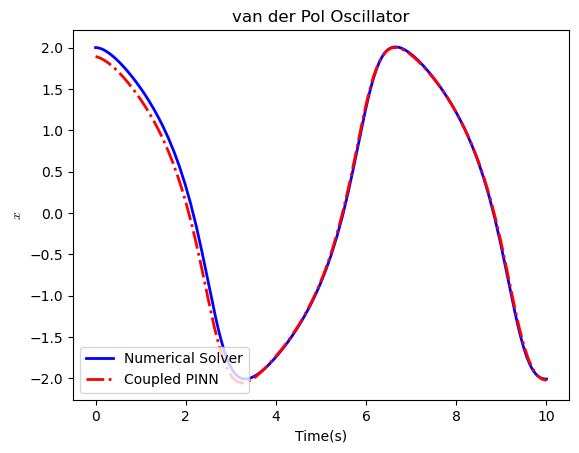

In [5]:
fig,ax = plt.subplots()
ax.plot(t,y1_true,'b',linewidth = 2,label = 'Numerical Solver')
ax.plot(x,y1_cP,'r-.',linewidth = 2,label = 'Coupled PINN')
ax.set_xlabel('Time(s)')
ax.set_ylabel('$x$',math_fontfamily = 'cm')
ax.set_title('van der Pol Oscillator')
ax.legend(loc = 3)

In [6]:
max(t)

array([10.])